#Numerical dataset- Lung cancer prediction using hyperparameter tuning

In [ ]:
!pip install bayesian-optimization

Null values:
 GENDER                   0
AGE                      0
SMOKING                  0
YELLOW_FINGERS           0
ANXIETY                  0
PEER_PRESSURE            0
CHRONIC DISEASE          0
FATIGUE                  0
ALLERGY                  0
WHEEZING                 0
ALCOHOL CONSUMING        0
COUGHING                 0
SHORTNESS OF BREATH      0
SWALLOWING DIFFICULTY    0
CHEST PAIN               0
LUNG_CANCER              0
dtype: int64
Categorical Columns: Index(['GENDER', 'LUNG_CANCER'], dtype='object')
Data after encoding:
    GENDER  AGE  SMOKING  YELLOW_FINGERS  ANXIETY  PEER_PRESSURE  \
0       1   69        1               2        2              1   
1       1   74        2               1        1              1   
2       0   59        1               1        1              2   
3       1   63        2               2        2              1   
4       0   63        1               2        1              1   

   CHRONIC DISEASE  FATIGUE   ALLERGY   WHEEZI

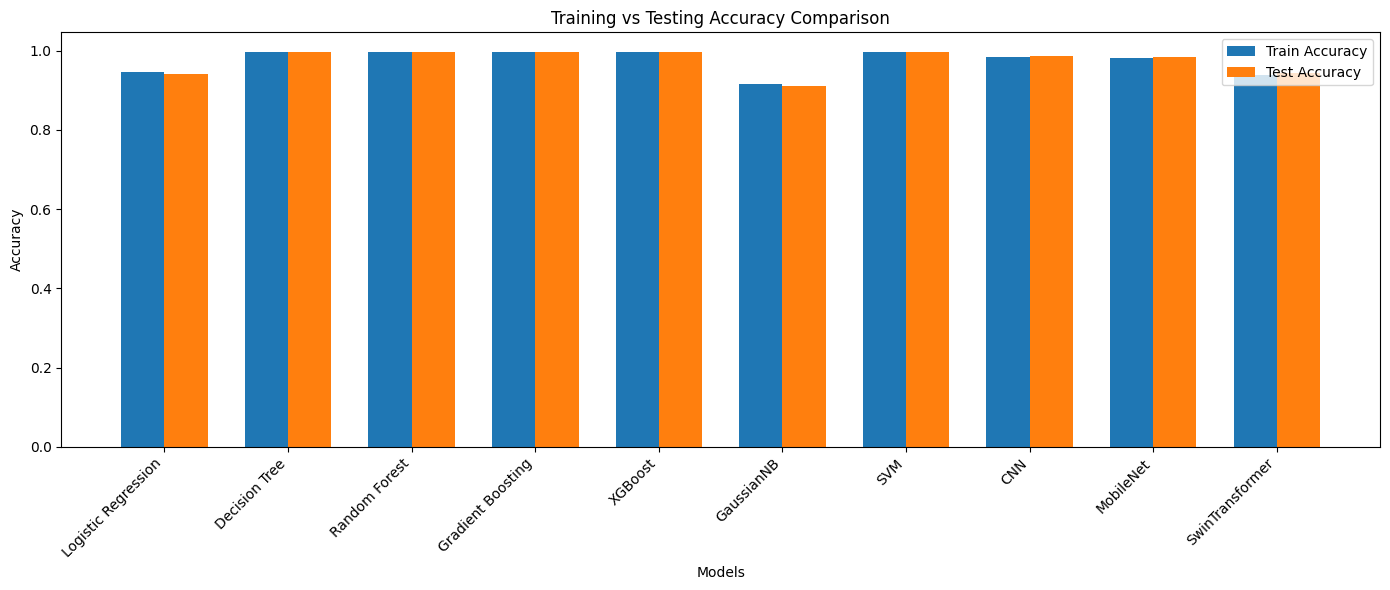

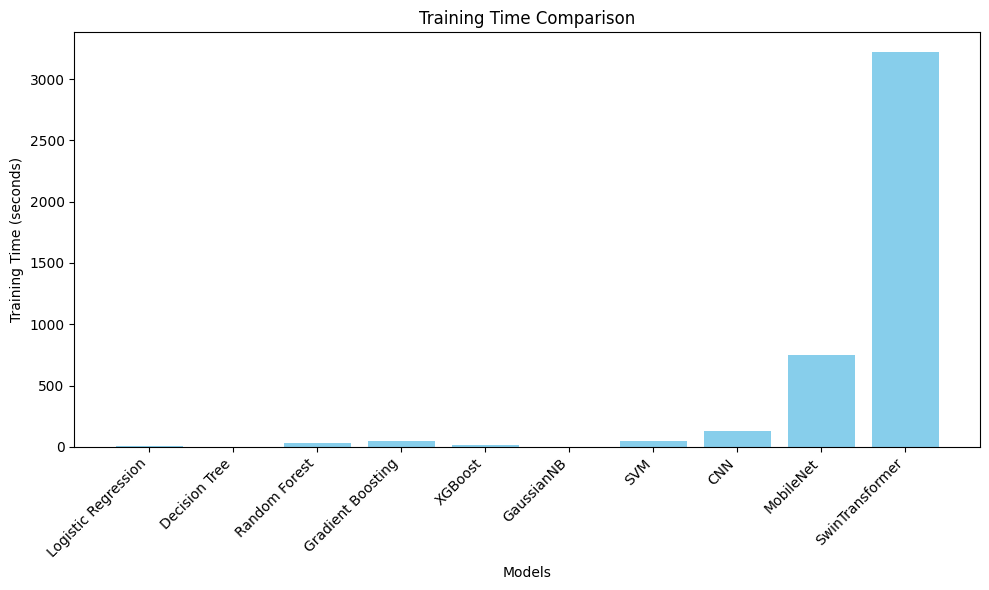

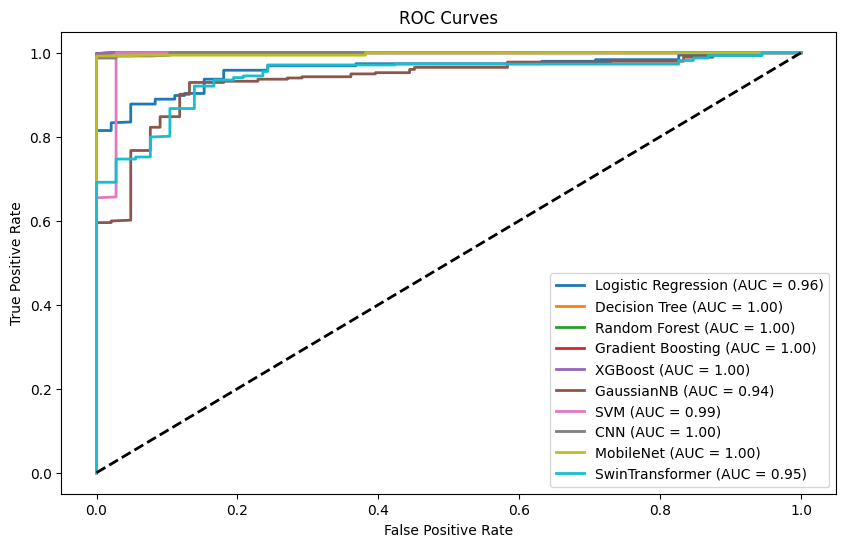

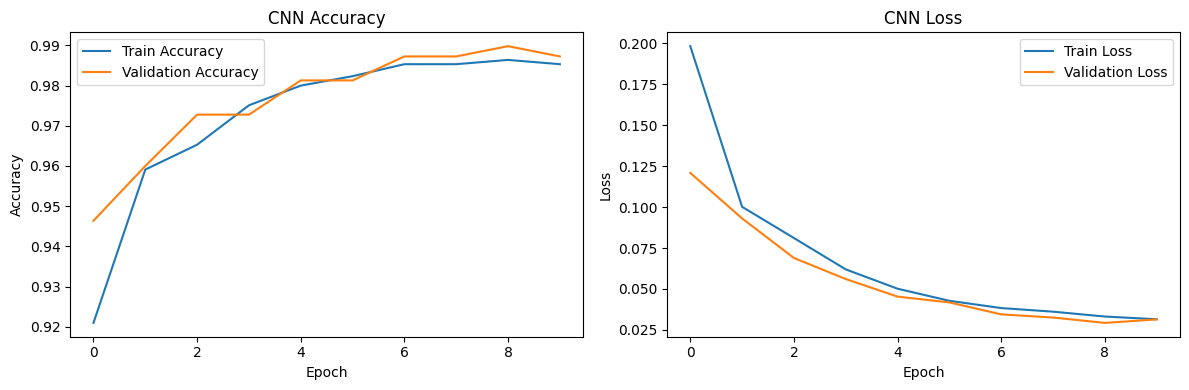

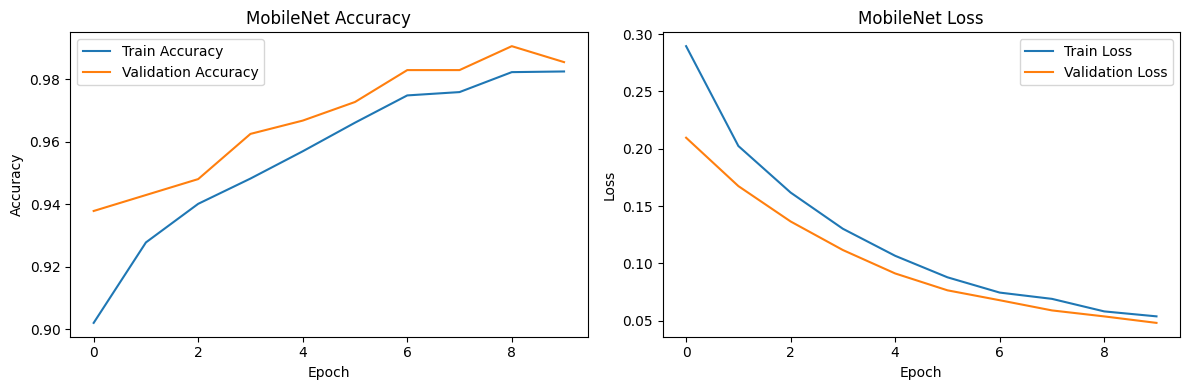

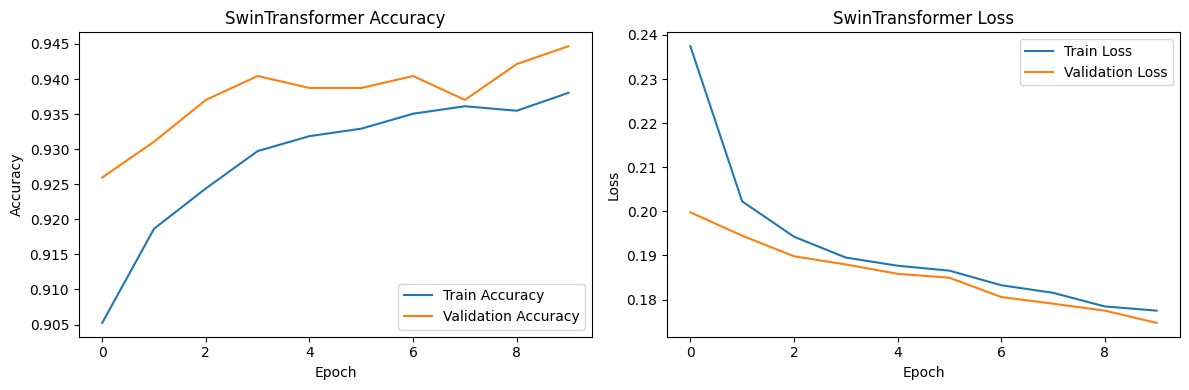

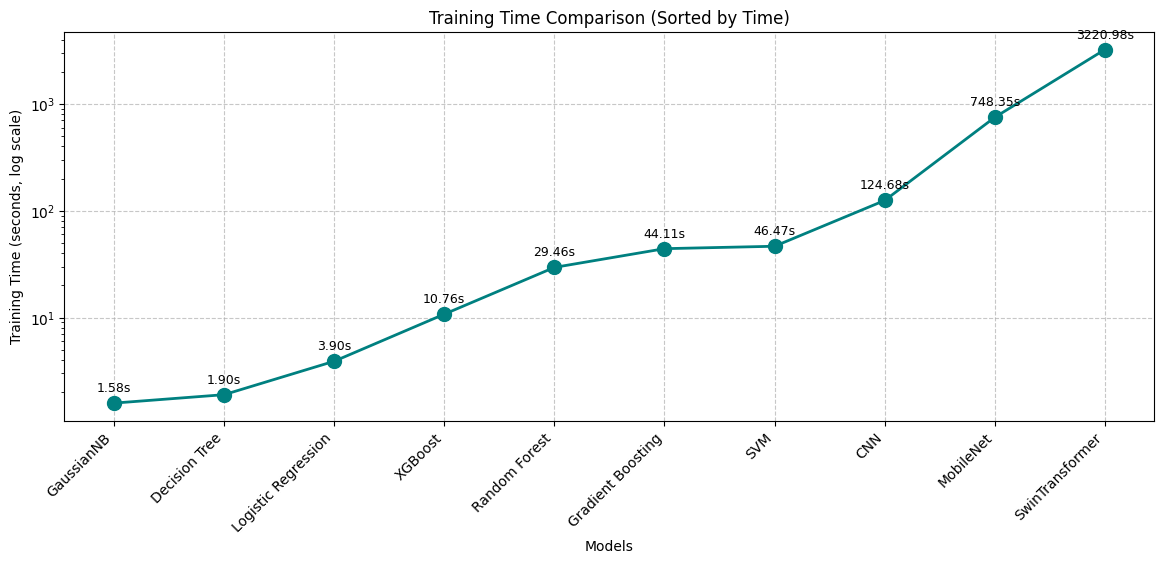

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, GlobalAveragePooling2D, Layer, Add
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import time
import warnings
from bayes_opt import BayesianOptimization

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset
df = pd.read_csv("lung cancer.csv")

# Check for null values
print("Null values:\n", df.isnull().sum())

# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print("Categorical Columns:", categorical_cols)

# Apply label encoding to categorical columns
label_encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

# Verify the transformation
print("Data after encoding:\n", df.head())

# Handle missing values with forward fill
df.fillna(method='ffill', inplace=True)

# Splitting data into features and target variable
X = df.drop('LUNG_CANCER', axis=1)
y = df['LUNG_CANCER']
print("Features shape:", X.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data for all models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Prepare data for CNN, MobileNet, and Swin Transformer (reshape to 2D/3D input)
num_features = X_train.shape[1]
min_size = int(np.ceil(np.sqrt(num_features)))
pad_size = min_size * min_size - num_features
if pad_size > 0:
    X_train_padded = np.pad(X_train_scaled, ((0, 0), (0, pad_size)), mode='constant')
    X_test_padded = np.pad(X_test_scaled, ((0, 0), (0, pad_size)), mode='constant')
else:
    X_train_padded = X_train_scaled
    X_test_padded = X_test_scaled

# Reshape for CNN
X_train_cnn = X_train_padded.reshape(-1, min_size, min_size, 1)
X_test_cnn = X_test_padded.reshape(-1, min_size, min_size, 1)

# For MobileNet and Swin Transformer, resize to at least 32x32x3
mobilenet_size = 32
X_train_mobilenet = np.repeat(X_train_cnn, mobilenet_size // min_size + 1, axis=1)[:, :mobilenet_size, :, :]
X_train_mobilenet = np.repeat(X_train_mobilenet, mobilenet_size // min_size + 1, axis=2)[:, :, :mobilenet_size, :]
X_test_mobilenet = np.repeat(X_test_cnn, mobilenet_size // min_size + 1, axis=1)[:, :mobilenet_size, :, :]
X_test_mobilenet = np.repeat(X_test_mobilenet, mobilenet_size // min_size + 1, axis=2)[:, :, :mobilenet_size, :]
X_train_mobilenet = np.repeat(X_train_mobilenet, 3, axis=3)
X_test_mobilenet = np.repeat(X_test_mobilenet, 3, axis=3)

# Swin Transformer uses same input as MobileNet
X_train_swin = X_train_mobilenet
X_test_swin = X_test_mobilenet

# Store models and metrics
best_models = {}
training_times = {}
train_accuracies = {}
test_accuracies = {}
history = {}
cv_scores = {'kfold': {}, 'stratified_kfold': {}, 'loo': {}}

# Bayesian Optimization Functions
def optimize_logistic(C):
    model = LogisticRegression(C=10**C, max_iter=500)
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
    return score

def optimize_decision_tree(max_depth, min_samples_split):
    model = DecisionTreeClassifier(max_depth=int(max_depth), min_samples_split=int(min_samples_split))
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
    return score

def optimize_random_forest(n_estimators, max_depth):
    model = RandomForestClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth))
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
    return score

def optimize_gradient_boosting(n_estimators, learning_rate, max_depth):
    model = GradientBoostingClassifier(n_estimators=int(n_estimators), learning_rate=learning_rate, max_depth=int(max_depth))
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
    return score

def optimize_xgboost(n_estimators, learning_rate, max_depth):
    model = XGBClassifier(n_estimators=int(n_estimators), learning_rate=learning_rate, max_depth=int(max_depth), use_label_encoder=False, eval_metric='logloss')
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
    return score

def optimize_gaussian_nb(var_smoothing):
    model = GaussianNB(var_smoothing=10**var_smoothing)
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
    return score

def optimize_svm(C, gamma):
    model = SVC(C=10**C, gamma=10**gamma, kernel='rbf', probability=True)
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
    return score

def optimize_cnn(filters1, filters2, dense_units, dropout_rate):
    model = Sequential([
        Conv2D(int(filters1), (3, 3), activation='relu', padding='same', input_shape=(min_size, min_size, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(int(filters2), (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(int(dense_units), activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train_cnn, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=0)
    return history.history['val_accuracy'][-1]

def optimize_mobilenet(dense_units, dropout_rate):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(mobilenet_size, mobilenet_size, 3))
    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(int(dense_units), activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train_mobilenet, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=0)
    return history.history['val_accuracy'][-1]

def optimize_swin_transformer(dense_units, dropout_rate):
    class SwinTransformerLayer(Layer):
        def __init__(self, dim=32, num_heads=4):
            super(SwinTransformerLayer, self).__init__()
            self.dim = dim
            self.num_heads = num_heads
            self.attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=dim // num_heads)
            self.dense = Dense(dim, activation='relu')
            self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
            self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
            self.add = tf.keras.layers.Add()

        def call(self, inputs):
            x = self.attention(inputs, inputs)
            x = self.norm1(self.add([inputs, x]))
            x_dense = self.dense(x)
            x = self.norm2(self.add([x, x_dense]))
            return x

    model = Sequential([
        tf.keras.layers.Input(shape=(mobilenet_size, mobilenet_size, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Reshape((-1, 32)),
        SwinTransformerLayer(dim=32, num_heads=4),
        tf.keras.layers.GlobalAveragePooling1D(),
        Dense(int(dense_units), activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train_swin, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=0)
    return history.history['val_accuracy'][-1]

# Model Training with Bayesian Optimization
pbounds = {
    'Logistic Regression': {'C': (-3, 2)},
    'Decision Tree': {'max_depth': (3, 10), 'min_samples_split': (2, 10)},
    'Random Forest': {'n_estimators': (50, 200), 'max_depth': (5, 20)},
    'Gradient Boosting': {'n_estimators': (50, 200), 'learning_rate': (0.01, 0.2), 'max_depth': (3, 10)},
    'XGBoost': {'n_estimators': (50, 200), 'learning_rate': (0.01, 0.2), 'max_depth': (3, 10)},
    'GaussianNB': {'var_smoothing': (-9, 0)},
    'SVM': {'C': (-2, 2), 'gamma': (-3, 1)},
    'CNN': {'filters1': (16, 64), 'filters2': (32, 128), 'dense_units': (64, 256), 'dropout_rate': (0.3, 0.7)},
    'MobileNet': {'dense_units': (64, 256), 'dropout_rate': (0.3, 0.7)},
    'SwinTransformer': {'dense_units': (64, 256), 'dropout_rate': (0.3, 0.7)}
}

# Convert y_train and y_test to NumPy arrays to avoid indexing issues
y_train = y_train.to_numpy() if isinstance(y_train, pd.Series) else y_train
y_test = y_test.to_numpy() if isinstance(y_test, pd.Series) else y_test

### Logistic Regression ###
start_time = time.time()
optimizer = BayesianOptimization(f=optimize_logistic, pbounds={'C': pbounds['Logistic Regression']['C']}, random_state=42)
optimizer.maximize(init_points=5, n_iter=10)
best_params = optimizer.max['params']
log_reg = LogisticRegression(C=10**best_params['C'], max_iter=500)
log_reg.fit(X_train_scaled, y_train)
best_models['Logistic Regression'] = log_reg
training_times['Logistic Regression'] = time.time() - start_time
train_accuracies['Logistic Regression'] = accuracy_score(y_train, log_reg.predict(X_train_scaled))
test_accuracies['Logistic Regression'] = accuracy_score(y_test, log_reg.predict(X_test_scaled))
cv_scores['kfold']['Logistic Regression'] = cross_val_score(log_reg, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
cv_scores['stratified_kfold']['Logistic Regression'] = cross_val_score(log_reg, X_train_scaled, y_train, cv=StratifiedKFold(5), scoring='accuracy').mean()
cv_scores['loo']['Logistic Regression'] = cross_val_score(log_reg, X_train_scaled, y_train, cv=LeaveOneOut(), scoring='accuracy').mean()

### Decision Tree ###
start_time = time.time()
optimizer = BayesianOptimization(f=optimize_decision_tree, pbounds=pbounds['Decision Tree'], random_state=42)
optimizer.maximize(init_points=5, n_iter=10)
best_params = optimizer.max['params']
dt = DecisionTreeClassifier(max_depth=int(best_params['max_depth']), min_samples_split=int(best_params['min_samples_split']))
dt.fit(X_train_scaled, y_train)
best_models['Decision Tree'] = dt
training_times['Decision Tree'] = time.time() - start_time
train_accuracies['Decision Tree'] = accuracy_score(y_train, dt.predict(X_train_scaled))
test_accuracies['Decision Tree'] = accuracy_score(y_test, dt.predict(X_test_scaled))
cv_scores['kfold']['Decision Tree'] = cross_val_score(dt, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
cv_scores['stratified_kfold']['Decision Tree'] = cross_val_score(dt, X_train_scaled, y_train, cv=StratifiedKFold(5), scoring='accuracy').mean()
cv_scores['loo']['Decision Tree'] = cross_val_score(dt, X_train_scaled, y_train, cv=LeaveOneOut(), scoring='accuracy').mean()

### Random Forest ###
start_time = time.time()
optimizer = BayesianOptimization(f=optimize_random_forest, pbounds=pbounds['Random Forest'], random_state=42)
optimizer.maximize(init_points=5, n_iter=10)
best_params = optimizer.max['params']
rf = RandomForestClassifier(n_estimators=int(best_params['n_estimators']), max_depth=int(best_params['max_depth']))
rf.fit(X_train_scaled, y_train)
best_models['Random Forest'] = rf
training_times['Random Forest'] = time.time() - start_time
train_accuracies['Random Forest'] = accuracy_score(y_train, rf.predict(X_train_scaled))
test_accuracies['Random Forest'] = accuracy_score(y_test, rf.predict(X_test_scaled))
cv_scores['kfold']['Random Forest'] = cross_val_score(rf, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
cv_scores['stratified_kfold']['Random Forest'] = cross_val_score(rf, X_train_scaled, y_train, cv=StratifiedKFold(5), scoring='accuracy').mean()
cv_scores['loo']['Random Forest'] = cross_val_score(rf, X_train_scaled, y_train, cv=LeaveOneOut(), scoring='accuracy').mean()

### Gradient Boosting ###
start_time = time.time()
optimizer = BayesianOptimization(f=optimize_gradient_boosting, pbounds=pbounds['Gradient Boosting'], random_state=42)
optimizer.maximize(init_points=5, n_iter=10)
best_params = optimizer.max['params']
gb = GradientBoostingClassifier(n_estimators=int(best_params['n_estimators']), learning_rate=best_params['learning_rate'], max_depth=int(best_params['max_depth']))
gb.fit(X_train_scaled, y_train)
best_models['Gradient Boosting'] = gb
training_times['Gradient Boosting'] = time.time() - start_time
train_accuracies['Gradient Boosting'] = accuracy_score(y_train, gb.predict(X_train_scaled))
test_accuracies['Gradient Boosting'] = accuracy_score(y_test, gb.predict(X_test_scaled))
cv_scores['kfold']['Gradient Boosting'] = cross_val_score(gb, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
cv_scores['stratified_kfold']['Gradient Boosting'] = cross_val_score(gb, X_train_scaled, y_train, cv=StratifiedKFold(5), scoring='accuracy').mean()
cv_scores['loo']['Gradient Boosting'] = cross_val_score(gb, X_train_scaled, y_train, cv=LeaveOneOut(), scoring='accuracy').mean()

### XGBoost ###
start_time = time.time()
optimizer = BayesianOptimization(f=optimize_xgboost, pbounds=pbounds['XGBoost'], random_state=42)
optimizer.maximize(init_points=5, n_iter=10)
best_params = optimizer.max['params']
xgb = XGBClassifier(n_estimators=int(best_params['n_estimators']), learning_rate=best_params['learning_rate'], max_depth=int(best_params['max_depth']), use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_scaled, y_train)
best_models['XGBoost'] = xgb
training_times['XGBoost'] = time.time() - start_time
train_accuracies['XGBoost'] = accuracy_score(y_train, xgb.predict(X_train_scaled))
test_accuracies['XGBoost'] = accuracy_score(y_test, xgb.predict(X_test_scaled))
cv_scores['kfold']['XGBoost'] = cross_val_score(xgb, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
cv_scores['stratified_kfold']['XGBoost'] = cross_val_score(xgb, X_train_scaled, y_train, cv=StratifiedKFold(5), scoring='accuracy').mean()
cv_scores['loo']['XGBoost'] = cross_val_score(xgb, X_train_scaled, y_train, cv=LeaveOneOut(), scoring='accuracy').mean()

### Gaussian Naïve Bayes ###
start_time = time.time()
optimizer = BayesianOptimization(f=optimize_gaussian_nb, pbounds=pbounds['GaussianNB'], random_state=42)
optimizer.maximize(init_points=5, n_iter=10)
best_params = optimizer.max['params']
gnb = GaussianNB(var_smoothing=10**best_params['var_smoothing'])
gnb.fit(X_train_scaled, y_train)
best_models['GaussianNB'] = gnb
training_times['GaussianNB'] = time.time() - start_time
train_accuracies['GaussianNB'] = accuracy_score(y_train, gnb.predict(X_train_scaled))
test_accuracies['GaussianNB'] = accuracy_score(y_test, gnb.predict(X_test_scaled))
cv_scores['kfold']['GaussianNB'] = cross_val_score(gnb, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
cv_scores['stratified_kfold']['GaussianNB'] = cross_val_score(gnb, X_train_scaled, y_train, cv=StratifiedKFold(5), scoring='accuracy').mean()
cv_scores['loo']['GaussianNB'] = cross_val_score(gnb, X_train_scaled, y_train, cv=LeaveOneOut(), scoring='accuracy').mean()

### Support Vector Machine (SVM) ###
start_time = time.time()
optimizer = BayesianOptimization(f=optimize_svm, pbounds=pbounds['SVM'], random_state=42)
optimizer.maximize(init_points=5, n_iter=10)
best_params = optimizer.max['params']
svm = SVC(C=10**best_params['C'], gamma=10**best_params['gamma'], kernel='rbf', probability=True)
svm.fit(X_train_scaled, y_train)
best_models['SVM'] = svm
training_times['SVM'] = time.time() - start_time
train_accuracies['SVM'] = accuracy_score(y_train, svm.predict(X_train_scaled))
test_accuracies['SVM'] = accuracy_score(y_test, svm.predict(X_test_scaled))
cv_scores['kfold']['SVM'] = cross_val_score(svm, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
cv_scores['stratified_kfold']['SVM'] = cross_val_score(svm, X_train_scaled, y_train, cv=StratifiedKFold(5), scoring='accuracy').mean()
cv_scores['loo']['SVM'] = cross_val_score(svm, X_train_scaled, y_train, cv=LeaveOneOut(), scoring='accuracy').mean()

### CNN ###
start_time = time.time()
optimizer = BayesianOptimization(f=optimize_cnn, pbounds=pbounds['CNN'], random_state=42)
optimizer.maximize(init_points=5, n_iter=10)
best_params = optimizer.max['params']
cnn_model = Sequential([
    Conv2D(int(best_params['filters1']), (3, 3), activation='relu', padding='same', input_shape=(min_size, min_size, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(int(best_params['filters2']), (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(int(best_params['dense_units']), activation='relu'),
    Dropout(best_params['dropout_rate']),
    Dense(1, activation='sigmoid')
])
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history['CNN'] = cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_data=(X_test_cnn, y_test), verbose=0)
best_models['CNN'] = cnn_model
training_times['CNN'] = time.time() - start_time
train_accuracies['CNN'] = history['CNN'].history['accuracy'][-1]
test_accuracies['CNN'] = history['CNN'].history['val_accuracy'][-1]
cv_scores['kfold']['CNN'] = np.mean([cnn_model.evaluate(X_train_cnn[train_idx], y_train[train_idx], verbose=0)[1] for train_idx, _ in StratifiedKFold(5).split(X_train_cnn, y_train)])
cv_scores['stratified_kfold']['CNN'] = cv_scores['kfold']['CNN']  # Same as kfold for neural networks
cv_scores['loo']['CNN'] = np.mean([cnn_model.evaluate(X_train_cnn[[i]], y_train[i:i+1], verbose=0)[1] for i in range(len(X_train_cnn))])

### MobileNet ###
start_time = time.time()
optimizer = BayesianOptimization(f=optimize_mobilenet, pbounds=pbounds['MobileNet'], random_state=42)
optimizer.maximize(init_points=5, n_iter=10)
best_params = optimizer.max['params']
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(mobilenet_size, mobilenet_size, 3))
base_model.trainable = False
mobilenet_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(int(best_params['dense_units']), activation='relu'),
    Dropout(best_params['dropout_rate']),
    Dense(1, activation='sigmoid')
])
mobilenet_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history['MobileNet'] = mobilenet_model.fit(X_train_mobilenet, y_train, epochs=10, batch_size=32, validation_data=(X_test_mobilenet, y_test), verbose=0)
best_models['MobileNet'] = mobilenet_model
training_times['MobileNet'] = time.time() - start_time
train_accuracies['MobileNet'] = history['MobileNet'].history['accuracy'][-1]
test_accuracies['MobileNet'] = history['MobileNet'].history['val_accuracy'][-1]
cv_scores['kfold']['MobileNet'] = np.mean([mobilenet_model.evaluate(X_train_mobilenet[train_idx], y_train[train_idx], verbose=0)[1] for train_idx, _ in StratifiedKFold(5).split(X_train_mobilenet, y_train)])
cv_scores['stratified_kfold']['MobileNet'] = cv_scores['kfold']['MobileNet']
cv_scores['loo']['MobileNet'] = np.mean([mobilenet_model.evaluate(X_train_mobilenet[[i]], y_train[i:i+1], verbose=0)[1] for i in range(len(X_train_mobilenet))])

### Swin Transformer ###
start_time = time.time()
optimizer = BayesianOptimization(f=optimize_swin_transformer, pbounds=pbounds['SwinTransformer'], random_state=42)
optimizer.maximize(init_points=5, n_iter=10)
best_params = optimizer.max['params']
class SwinTransformerLayer(Layer):
    def __init__(self, dim=32, num_heads=4):
        super(SwinTransformerLayer, self).__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=dim // num_heads)
        self.dense = Dense(dim, activation='relu')
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.add = tf.keras.layers.Add()

    def call(self, inputs):
        x = self.attention(inputs, inputs)
        x = self.norm1(self.add([inputs, x]))
        x_dense = self.dense(x)
        x = self.norm2(self.add([x, x_dense]))
        return x

swin_model = Sequential([
    tf.keras.layers.Input(shape=(mobilenet_size, mobilenet_size, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Reshape((-1, 32)),
    SwinTransformerLayer(dim=32, num_heads=4),
    tf.keras.layers.GlobalAveragePooling1D(),
    Dense(int(best_params['dense_units']), activation='relu'),
    Dropout(best_params['dropout_rate']),
    Dense(1, activation='sigmoid')
])
swin_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history['SwinTransformer'] = swin_model.fit(X_train_swin, y_train, epochs=10, batch_size=32, validation_data=(X_test_swin, y_test), verbose=0)
best_models['SwinTransformer'] = swin_model
training_times['SwinTransformer'] = time.time() - start_time
train_accuracies['SwinTransformer'] = history['SwinTransformer'].history['accuracy'][-1]
test_accuracies['SwinTransformer'] = history['SwinTransformer'].history['val_accuracy'][-1]
cv_scores['kfold']['SwinTransformer'] = np.mean([swin_model.evaluate(X_train_swin[train_idx], y_train[train_idx], verbose=0)[1] for train_idx, _ in StratifiedKFold(5).split(X_train_swin, y_train)])
cv_scores['stratified_kfold']['SwinTransformer'] = cv_scores['kfold']['SwinTransformer']
cv_scores['loo']['SwinTransformer'] = np.mean([swin_model.evaluate(X_train_swin[[i]], y_train[i:i+1], verbose=0)[1] for i in range(len(X_train_swin))])

# Evaluate models and collect metrics
model_results = {}
model_names = list(best_models.keys())

for model_name, model in best_models.items():
    if model_name in ['CNN', 'MobileNet', 'SwinTransformer']:
        if model_name == 'CNN':
            y_prob = model.predict(X_test_cnn, verbose=0).flatten()
        else:
            y_prob = model.predict(X_test_swin, verbose=0).flatten()
        y_pred = (y_prob >= 0.5).astype(int)
    else:
        y_prob = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else model.predict(X_test_scaled)
        y_pred = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
    recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)
    conf_matrix = confusion_matrix(y_test, y_pred)

    TN, FP, FN, TP = conf_matrix.ravel()
    specificity = TN / (TN + FP) if (TN + FP) > 0 else np.nan

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    model_results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1-Score': f1,
        'Confusion Matrix': conf_matrix,
        'ROC AUC': roc_auc,
        'FPR': fpr,
        'TPR': tpr
    }

# Print training times
print("\n🔹 Training Times 🔹")
for model_name, train_time in training_times.items():
    print(f"{model_name}: {train_time:.2f} seconds")

# Print evaluation results
for model, metrics in model_results.items():
    print(f"\n🔹 {model} Evaluation 🔹")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall (Sensitivity): {metrics['Recall']:.4f}")
    print(f"Specificity: {metrics['Specificity']:.4f}")
    print(f"F1-Score: {metrics['F1-Score']:.4f}")
    print(f"Confusion Matrix:\n{metrics['Confusion Matrix']}")
    print("-" * 50)

# Create summary table
summary_data = {
    'Model': model_names,
    'Train Accuracy': [train_accuracies[m] for m in model_names],
    'Test Accuracy': [test_accuracies[m] for m in model_names],
    'Precision': [model_results[m]['Precision'] for m in model_names],
    'Recall': [model_results[m]['Recall'] for m in model_names],
    'F1-Score': [model_results[m]['F1-Score'] for m in model_names],
    'K-Fold CV': [cv_scores['kfold'][m] for m in model_names],
    'Stratified K-Fold CV': [cv_scores['stratified_kfold'][m] for m in model_names],
    'LOO CV': [cv_scores['loo'][m] for m in model_names],
    'Training Time (s)': [training_times[m] for m in model_names]
}

summary_df = pd.DataFrame(summary_data)
print("\n🔹 Final Summary Table 🔹")
print(summary_df.to_string(index=False))

# Identify the best model based on test accuracy
best_model_name = summary_df.loc[summary_df['Test Accuracy'].idxmax(), 'Model']
best_model_score = summary_df['Test Accuracy'].max()
print(f"\n🔹 Best Model for Lung Cancer Prediction 🔹")
print(f"Model: {best_model_name}")
print(f"Test Accuracy: {best_model_score:.4f}")

# Plot training vs testing accuracy
plt.figure(figsize=(14, 6))
x = np.arange(len(model_names))
width = 0.35
plt.bar(x - width/2, [train_accuracies[m] for m in model_names], width, label='Train Accuracy')
plt.bar(x + width/2, [test_accuracies[m] for m in model_names], width, label='Test Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy Comparison')
plt.xticks(x, model_names, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Plot training times
plt.figure(figsize=(10, 6))
plt.bar(model_names, [training_times[m] for m in model_names], color='skyblue')
plt.xlabel('Models')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time Comparison')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot ROC curves
plt.figure(figsize=(10, 6))
for model_name, metrics in model_results.items():
    plt.plot(metrics['FPR'], metrics['TPR'], lw=2, label=f'{model_name} (AUC = {metrics["ROC AUC"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

# Plot training history for neural networks
for model_name in ['CNN', 'MobileNet', 'SwinTransformer']:
    if model_name in history:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history[model_name].history['accuracy'], label='Train Accuracy')
        plt.plot(history[model_name].history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'{model_name} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history[model_name].history['loss'], label='Train Loss')
        plt.plot(history[model_name].history['val_loss'], label='Validation Loss')
        plt.title(f'{model_name} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        plt.show()

# Sorted training times plot
sorted_models = sorted(training_times.items(), key=lambda x: x[1])
model_names_sorted = [m[0] for m in sorted_models]
times_sorted = [m[1] for m in sorted_models]

plt.figure(figsize=(12, 6))
plt.plot(model_names_sorted, times_sorted, marker='o', linestyle='-', color='teal', linewidth=2, markersize=10)
plt.yscale('log')
plt.ylabel('Training Time (seconds, log scale)')
plt.xlabel('Models')
plt.title('Training Time Comparison (Sorted by Time)')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
for i, time in enumerate(times_sorted):
    plt.text(i, time * 1.2, f'{time:.2f}s', ha='center', va='bottom', fontsize=9, color='black')
plt.margins(x=0.05)
plt.tight_layout(pad=2.0)
plt.show()

# corrected

In [ ]:
!pip install bayesian-optimization

Null values:
 GENDER                   0
AGE                      0
SMOKING                  0
YELLOW_FINGERS           0
ANXIETY                  0
PEER_PRESSURE            0
CHRONIC DISEASE          0
FATIGUE                  0
ALLERGY                  0
WHEEZING                 0
ALCOHOL CONSUMING        0
COUGHING                 0
SHORTNESS OF BREATH      0
SWALLOWING DIFFICULTY    0
CHEST PAIN               0
LUNG_CANCER              0
dtype: int64
Categorical Columns: Index(['GENDER', 'LUNG_CANCER'], dtype='object')
Data after encoding:
    GENDER  AGE  SMOKING  YELLOW_FINGERS  ANXIETY  PEER_PRESSURE  \
0       1   69        1               2        2              1   
1       1   74        2               1        1              1   
2       0   59        1               1        1              2   
3       1   63        2               2        2              1   
4       0   63        1               2        1              1   

   CHRONIC DISEASE  FATIGUE   ALLERGY   WHEEZI

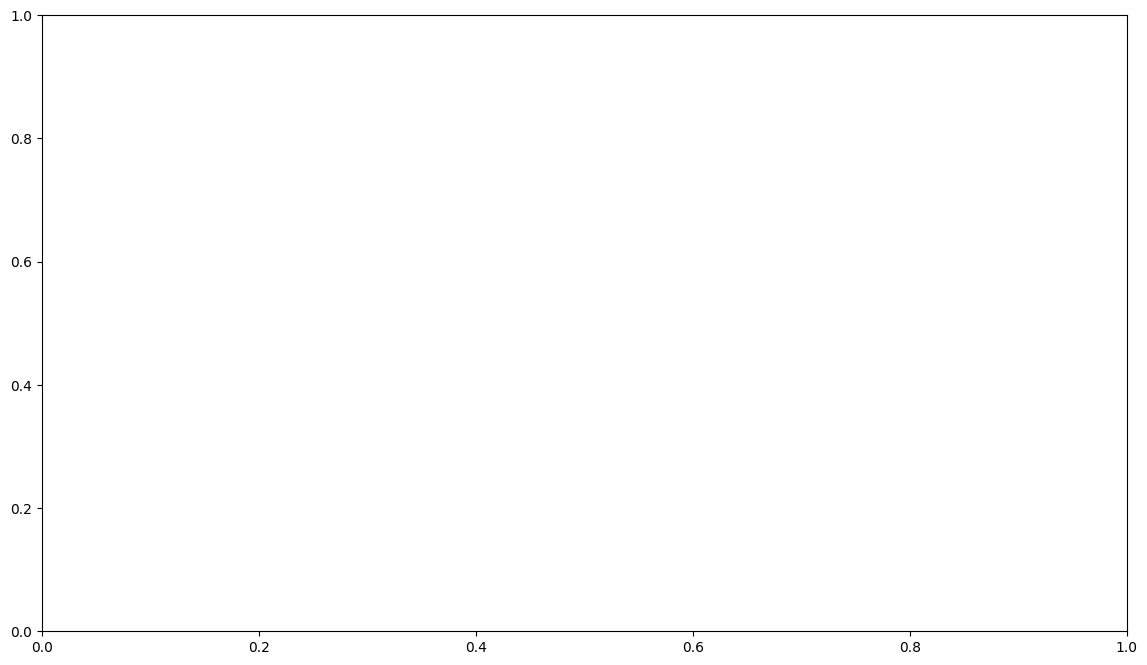

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, GlobalAveragePooling2D, Layer
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import time
import warnings
from bayes_opt import BayesianOptimization

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset
df = pd.read_csv("lung cancer.csv")

# Check for null values
print("Null values:\n", df.isnull().sum())

# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print("Categorical Columns:", categorical_cols)

# Apply label encoding to categorical columns
label_encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

# Verify the transformation
print("Data after encoding:\n", df.head())

# Handle missing values with forward fill
df.fillna(method='ffill', inplace=True)

# Splitting data into features and target variable
X = df.drop('LUNG_CANCER', axis=1)
y = df['LUNG_CANCER']
print("Features shape:", X.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data for all models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Prepare data for CNN, MobileNet, and Swin Transformer
num_features = X_train.shape[1]
min_size = int(np.ceil(np.sqrt(num_features)))
pad_size = min_size * min_size - num_features
if pad_size > 0:
    X_train_padded = np.pad(X_train_scaled, ((0, 0), (0, pad_size)), mode='constant')
    X_test_padded = np.pad(X_test_scaled, ((0, 0), (0, pad_size)), mode='constant')
else:
    X_train_padded = X_train_scaled
    X_test_padded = X_test_scaled

# Reshape for CNN
X_train_cnn = X_train_padded.reshape(-1, min_size, min_size, 1)
X_test_cnn = X_test_padded.reshape(-1, min_size, min_size, 1)

# For MobileNet and Swin Transformer, resize to at least 32x32x3
mobilenet_size = 32
X_train_mobilenet = np.repeat(X_train_cnn, mobilenet_size // min_size + 1, axis=1)[:, :mobilenet_size, :, :]
X_train_mobilenet = np.repeat(X_train_mobilenet, mobilenet_size // min_size + 1, axis=2)[:, :, :mobilenet_size, :]
X_test_mobilenet = np.repeat(X_test_cnn, mobilenet_size // min_size + 1, axis=1)[:, :mobilenet_size, :, :]
X_test_mobilenet = np.repeat(X_test_mobilenet, mobilenet_size // min_size + 1, axis=2)[:, :, :mobilenet_size, :]
X_train_mobilenet = np.repeat(X_train_mobilenet, 3, axis=3)
X_test_mobilenet = np.repeat(X_test_mobilenet, 3, axis=3)

# Swin Transformer uses same input as MobileNet
X_train_swin = X_train_mobilenet
X_test_swin = X_test_mobilenet

# Store models and metrics
models = {}
models_with_bayesian = {}
bayesian_results = {}
cv_scores = {'kfold': {}, 'stratified_kfold': {}, 'loo': {}}
cv_scores_with_bayesian = {'kfold': {}, 'stratified_kfold': {}, 'loo': {}}
metrics_data = {'Accuracy': {}, 'Precision': {}, 'Recall': {}, 'F1-Score': {}, 'AUC': {}}
metrics_data_with_bayesian = {'Accuracy': {}, 'Precision': {}, 'Recall': {}, 'F1-Score': {}, 'AUC': {}}

# Bayesian Optimization Functions
def optimize_logistic(C):
    model = LogisticRegression(C=10**C, max_iter=500)
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
    return score

def optimize_decision_tree(max_depth, min_samples_split):
    model = DecisionTreeClassifier(max_depth=int(max_depth), min_samples_split=int(min_samples_split))
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
    return score

def optimize_random_forest(n_estimators, max_depth):
    model = RandomForestClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth))
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
    return score

def optimize_gradient_boosting(n_estimators, learning_rate, max_depth):
    model = GradientBoostingClassifier(n_estimators=int(n_estimators), learning_rate=learning_rate, max_depth=int(max_depth))
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
    return score

def optimize_xgboost(n_estimators, learning_rate, max_depth):
    model = XGBClassifier(n_estimators=int(n_estimators), learning_rate=learning_rate, max_depth=int(max_depth), use_label_encoder=False, eval_metric='logloss')
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
    return score

def optimize_gaussian_nb(var_smoothing):
    model = GaussianNB(var_smoothing=10**var_smoothing)
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
    return score

def optimize_svm(C, gamma):
    model = SVC(C=10**C, gamma=10**gamma, kernel='rbf', probability=True)
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
    return score

def optimize_cnn(filters1, filters2, dense_units, dropout_rate):
    model = Sequential([
        Conv2D(int(filters1), (3, 3), activation='relu', padding='same', input_shape=(min_size, min_size, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(int(filters2), (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(int(dense_units), activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train_cnn, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=0)
    return history.history['val_accuracy'][-1]

def optimize_mobilenet(dense_units, dropout_rate):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(mobilenet_size, mobilenet_size, 3))
    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(int(dense_units), activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train_mobilenet, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=0)
    return history.history['val_accuracy'][-1]

def optimize_swin_transformer(dense_units, dropout_rate):
    class SwinTransformerLayer(Layer):
        def __init__(self, dim=32, num_heads=4):
            super(SwinTransformerLayer, self).__init__()
            self.dim = dim
            self.num_heads = num_heads
            self.attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=dim // num_heads)
            self.dense = Dense(dim, activation='relu')
            self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
            self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
            self.add = tf.keras.layers.Add()

        def call(self, inputs):
            x = self.attention(inputs, inputs)
            x = self.norm1(self.add([inputs, x]))
            x_dense = self.dense(x)
            x = self.norm2(self.add([x, x_dense]))
            return x

    model = Sequential([
        tf.keras.layers.Input(shape=(mobilenet_size, mobilenet_size, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Reshape((-1, 32)),
        SwinTransformerLayer(dim=32, num_heads=4),
        tf.keras.layers.GlobalAveragePooling1D(),
        Dense(int(dense_units), activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train_swin, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=0)
    return history.history['val_accuracy'][-1]

# Define parameter bounds for Bayesian Optimization
pbounds = {
    'Logistic Regression': {'C': (-3, 2)},
    'Decision Tree': {'max_depth': (3, 10), 'min_samples_split': (2, 10)},
    'Random Forest': {'n_estimators': (50, 200), 'max_depth': (5, 20)},
    'Gradient Boosting': {'n_estimators': (50, 200), 'learning_rate': (0.01, 0.2), 'max_depth': (3, 10)},
    'XGBoost': {'n_estimators': (50, 200), 'learning_rate': (0.01, 0.2), 'max_depth': (3, 10)},
    'GaussianNB': {'var_smoothing': (-9, 0)},
    'SVM': {'C': (-2, 2), 'gamma': (-3, 1)},
    'CNN': {'filters1': (16, 64), 'filters2': (32, 128), 'dense_units': (64, 256), 'dropout_rate': (0.3, 0.7)},
    'MobileNet': {'dense_units': (64, 256), 'dropout_rate': (0.3, 0.7)},
    'SwinTransformer': {'dense_units': (64, 256), 'dropout_rate': (0.3, 0.7)}
}

# Convert y_train and y_test to NumPy arrays
y_train = y_train.to_numpy() if isinstance(y_train, pd.Series) else y_train
y_test = y_test.to_numpy() if isinstance(y_test, pd.Series) else y_test

# Model Training with and without Bayesian Optimization
model_configs = [
    ('Logistic Regression', optimize_logistic, LogisticRegression, {'C': 'C'}),
    ('Decision Tree', optimize_decision_tree, DecisionTreeClassifier, {'max_depth': 'max_depth', 'min_samples_split': 'min_samples_split'}),
    ('Random Forest', optimize_random_forest, RandomForestClassifier, {'n_estimators': 'n_estimators', 'max_depth': 'max_depth'}),
    ('Gradient Boosting', optimize_gradient_boosting, GradientBoostingClassifier, {'n_estimators': 'n_estimators', 'learning_rate': 'learning_rate', 'max_depth': 'max_depth'}),
    ('XGBoost', optimize_xgboost, XGBClassifier, {'n_estimators': 'n_estimators', 'learning_rate': 'learning_rate', 'max_depth': 'max_depth'}),
    ('GaussianNB', optimize_gaussian_nb, GaussianNB, {'var_smoothing': 'var_smoothing'}),
    ('SVM', optimize_svm, SVC, {'C': 'C', 'gamma': 'gamma'}),
    ('CNN', optimize_cnn, None, {'filters1': 'filters1', 'filters2': 'filters2', 'dense_units': 'dense_units', 'dropout_rate': 'dropout_rate'}),
    ('MobileNet', optimize_mobilenet, None, {'dense_units': 'dense_units', 'dropout_rate': 'dropout_rate'}),
    ('SwinTransformer', optimize_swin_transformer, None, {'dense_units': 'dense_units', 'dropout_rate': 'dropout_rate'})
]

for model_name, optimize_func, model_class, param_mapping in model_configs:
    # Train model without Bayesian Optimization (default parameters)
    if model_name == 'Logistic Regression':
        model = LogisticRegression(max_iter=500)
        model.fit(X_train_scaled, y_train)
    elif model_name == 'Decision Tree':
        model = DecisionTreeClassifier()
        model.fit(X_train_scaled, y_train)
    elif model_name == 'Random Forest':
        model = RandomForestClassifier()
        model.fit(X_train_scaled, y_train)
    elif model_name == 'Gradient Boosting':
        model = GradientBoostingClassifier()
        model.fit(X_train_scaled, y_train)
    elif model_name == 'XGBoost':
        model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
        model.fit(X_train_scaled, y_train)
    elif model_name == 'GaussianNB':
        model = GaussianNB()
        model.fit(X_train_scaled, y_train)
    elif model_name == 'SVM':
        model = SVC(kernel='rbf', probability=True)
        model.fit(X_train_scaled, y_train)
    elif model_name == 'CNN':
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(min_size, min_size, 1)),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_data=(X_test_cnn, y_test), verbose=0)
    elif model_name == 'MobileNet':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(mobilenet_size, mobilenet_size, 3))
        base_model.trainable = False
        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_train_mobilenet, y_train, epochs=10, batch_size=32, validation_data=(X_test_mobilenet, y_test), verbose=0)
    elif model_name == 'SwinTransformer':
        class SwinTransformerLayer(Layer):
            def __init__(self, dim=32, num_heads=4):
                super(SwinTransformerLayer, self).__init__()
                self.dim = dim
                self.num_heads = num_heads
                self.attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=dim // num_heads)
                self.dense = Dense(dim, activation='relu')
                self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
                self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
                self.add = tf.keras.layers.Add()

            def call(self, inputs):
                x = self.attention(inputs, inputs)
                x = self.norm1(self.add([inputs, x]))
                x_dense = self.dense(x)
                x = self.norm2(self.add([x, x_dense]))
                return x

        model = Sequential([
            tf.keras.layers.Input(shape=(mobilenet_size, mobilenet_size, 3)),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Reshape((-1, 32)),
            SwinTransformerLayer(dim=32, num_heads=4),
            tf.keras.layers.GlobalAveragePooling1D(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_train_swin, y_train, epochs=10, batch_size=32, validation_data=(X_test_swin, y_test), verbose=0)

    models[model_name] = model

    # Evaluate model without Bayesian Optimization
    if model_name in ['CNN', 'MobileNet', 'SwinTransformer']:
        if model_name == 'CNN':
            y_prob = model.predict(X_test_cnn, verbose=0).flatten()
        else:
            y_prob = model.predict(X_test_swin, verbose=0).flatten()
        y_pred = (y_prob >= 0.5).astype(int)
    else:
        y_prob = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else model.predict(X_test_scaled)
        y_pred = model.predict(X_test_scaled)

    metrics_data['Accuracy'][model_name] = accuracy_score(y_test, y_pred)
    metrics_data['Precision'][model_name] = precision_score(y_test, y_pred, average='binary', zero_division=0)
    metrics_data['Recall'][model_name] = recall_score(y_test, y_pred, average='binary', zero_division=0)
    metrics_data['F1-Score'][model_name] = f1_score(y_test, y_pred, average='binary', zero_division=0)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    metrics_data['AUC'][model_name] = auc(fpr, tpr)

    # Perform cross-validation without Bayesian Optimization
    if model_name in ['CNN', 'MobileNet', 'SwinTransformer']:
        if model_name == 'CNN':
            cv_scores['kfold'][model_name] = np.mean([model.evaluate(X_train_cnn[train_idx], y_train[train_idx], verbose=0)[1] for train_idx, _ in StratifiedKFold(5).split(X_train_cnn, y_train)])
            cv_scores['stratified_kfold'][model_name] = cv_scores['kfold'][model_name]
            cv_scores['loo'][model_name] = np.mean([model.evaluate(X_train_cnn[[i]], y_train[i:i+1], verbose=0)[1] for i in range(len(X_train_cnn))])
        else:
            cv_scores['kfold'][model_name] = np.mean([model.evaluate(X_train_swin[train_idx], y_train[train_idx], verbose=0)[1] for train_idx, _ in StratifiedKFold(5).split(X_train_swin, y_train)])
            cv_scores['stratified_kfold'][model_name] = cv_scores['kfold'][model_name]
            cv_scores['loo'][model_name] = np.mean([model.evaluate(X_train_swin[[i]], y_train[i:i+1], verbose=0)[1] for i in range(len(X_train_swin))])
    else:
        cv_scores['kfold'][model_name] = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
        cv_scores['stratified_kfold'][model_name] = cross_val_score(model, X_train_scaled, y_train, cv=StratifiedKFold(5), scoring='accuracy').mean()
        cv_scores['loo'][model_name] = cross_val_score(model, X_train_scaled, y_train, cv=LeaveOneOut(), scoring='accuracy').mean()

    # Train model with Bayesian Optimization
    print(f"\n🔹 Optimizing {model_name} with Bayesian Optimization 🔹")
    optimizer = BayesianOptimization(f=optimize_func, pbounds=pbounds[model_name], random_state=42)
    optimizer.maximize(init_points=5, n_iter=10)
    best_params = optimizer.max['params']
    bayesian_results[model_name] = optimizer.max['target']
    print(f"Best Bayesian Optimization Score for {model_name}: {optimizer.max['target']:.4f}")
    print(f"Best Parameters: {best_params}")

    if model_name == 'Logistic Regression':
        model_with_bayesian = LogisticRegression(C=10**best_params['C'], max_iter=500)
        model_with_bayesian.fit(X_train_scaled, y_train)
    elif model_name == 'Decision Tree':
        model_with_bayesian = DecisionTreeClassifier(max_depth=int(best_params['max_depth']), min_samples_split=int(best_params['min_samples_split']))
        model_with_bayesian.fit(X_train_scaled, y_train)
    elif model_name == 'Random Forest':
        model_with_bayesian = RandomForestClassifier(n_estimators=int(best_params['n_estimators']), max_depth=int(best_params['max_depth']))
        model_with_bayesian.fit(X_train_scaled, y_train)
    elif model_name == 'Gradient Boosting':
        model_with_bayesian = GradientBoostingClassifier(n_estimators=int(best_params['n_estimators']), learning_rate=best_params['learning_rate'], max_depth=int(best_params['max_depth']))
        model_with_bayesian.fit(X_train_scaled, y_train)
    elif model_name == 'XGBoost':
        model_with_bayesian = XGBClassifier(n_estimators=int(best_params['n_estimators']), learning_rate=best_params['learning_rate'], max_depth=int(best_params['max_depth']), use_label_encoder=False, eval_metric='logloss')
        model_with_bayesian.fit(X_train_scaled, y_train)
    elif model_name == 'GaussianNB':
        model_with_bayesian = GaussianNB(var_smoothing=10**best_params['var_smoothing'])
        model_with_bayesian.fit(X_train_scaled, y_train)
    elif model_name == 'SVM':
        model_with_bayesian = SVC(C=10**best_params['C'], gamma=10**best_params['gamma'], kernel='rbf', probability=True)
        model_with_bayesian.fit(X_train_scaled, y_train)
    elif model_name == 'CNN':
        model_with_bayesian = Sequential([
            Conv2D(int(best_params['filters1']), (3, 3), activation='relu', padding='same', input_shape=(min_size, min_size, 1)),
            MaxPooling2D((2, 2)),
            Conv2D(int(best_params['filters2']), (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(int(best_params['dense_units']), activation='relu'),
            Dropout(best_params['dropout_rate']),
            Dense(1, activation='sigmoid')
        ])
        model_with_bayesian.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
        model_with_bayesian.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_data=(X_test_cnn, y_test), verbose=0)
    elif model_name == 'MobileNet':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(mobilenet_size, mobilenet_size, 3))
        base_model.trainable = False
        model_with_bayesian = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(int(best_params['dense_units']), activation='relu'),
            Dropout(best_params['dropout_rate']),
            Dense(1, activation='sigmoid')
        ])
        model_with_bayesian.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
        model_with_bayesian.fit(X_train_mobilenet, y_train, epochs=10, batch_size=32, validation_data=(X_test_mobilenet, y_test), verbose=0)
    elif model_name == 'SwinTransformer':
        class SwinTransformerLayer(Layer):
            def __init__(self, dim=32, num_heads=4):
                super(SwinTransformerLayer, self).__init__()
                self.dim = dim
                self.num_heads = num_heads
                self.attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=dim // num_heads)
                self.dense = Dense(dim, activation='relu')
                self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
                self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
                self.add = tf.keras.layers.Add()

            def call(self, inputs):
                x = self.attention(inputs, inputs)
                x = self.norm1(self.add([inputs, x]))
                x_dense = self.dense(x)
                x = self.norm2(self.add([x, x_dense]))
                return x

        model_with_bayesian = Sequential([
            tf.keras.layers.Input(shape=(mobilenet_size, mobilenet_size, 3)),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Reshape((-1, 32)),
            SwinTransformerLayer(dim=32, num_heads=4),
            tf.keras.layers.GlobalAveragePooling1D(),
            Dense(int(best_params['dense_units']), activation='relu'),
            Dropout(best_params['dropout_rate']),
            Dense(1, activation='sigmoid')
        ])
        model_with_bayesian.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
        model_with_bayesian.fit(X_train_swin, y_train, epochs=10, batch_size=32, validation_data=(X_test_swin, y_test), verbose=0)

    models_with_bayesian[f"{model_name} + Bayesian Optimization"] = model_with_bayesian

    # Evaluate model with Bayesian Optimization
    if model_name in ['CNN', 'MobileNet', 'SwinTransformer']:
        if model_name == 'CNN':
            y_prob = model_with_bayesian.predict(X_test_cnn, verbose=0).flatten()
        else:
            y_prob = model_with_bayesian.predict(X_test_swin, verbose=0).flatten()
        y_pred = (y_prob >= 0.5).astype(int)
    else:
        y_prob = model_with_bayesian.predict_proba(X_test_scaled)[:, 1] if hasattr(model_with_bayesian, 'predict_proba') else model_with_bayesian.predict(X_test_scaled)
        y_pred = model_with_bayesian.predict(X_test_scaled)

    metrics_data_with_bayesian['Accuracy'][f"{model_name} + Bayesian Optimization"] = accuracy_score(y_test, y_pred)
    metrics_data_with_bayesian['Precision'][f"{model_name} + Bayesian Optimization"] = precision_score(y_test, y_pred, average='binary', zero_division=0)
    metrics_data_with_bayesian['Recall'][f"{model_name} + Bayesian Optimization"] = recall_score(y_test, y_pred, average='binary', zero_division=0)
    metrics_data_with_bayesian['F1-Score'][f"{model_name} + Bayesian Optimization"] = f1_score(y_test, y_pred, average='binary', zero_division=0)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    metrics_data_with_bayesian['AUC'][f"{model_name} + Bayesian Optimization"] = auc(fpr, tpr)

    # Perform cross-validation with Bayesian Optimization
    if model_name in ['CNN', 'MobileNet', 'SwinTransformer']:
        if model_name == 'CNN':
            cv_scores_with_bayesian['kfold'][f"{model_name} + Bayesian Optimization"] = np.mean([model_with_bayesian.evaluate(X_train_cnn[train_idx], y_train[train_idx], verbose=0)[1] for train_idx, _ in StratifiedKFold(5).split(X_train_cnn, y_train)])
            cv_scores_with_bayesian['stratified_kfold'][f"{model_name} + Bayesian Optimization"] = cv_scores_with_bayesian['kfold'][f"{model_name} + Bayesian Optimization"]
            cv_scores_with_bayesian['loo'][f"{model_name} + Bayesian Optimization"] = np.mean([model_with_bayesian.evaluate(X_train_cnn[[i]], y_train[i:i+1], verbose=0)[1] for i in range(len(X_train_cnn))])
        else:
            cv_scores_with_bayesian['kfold'][f"{model_name} + Bayesian Optimization"] = np.mean([model_with_bayesian.evaluate(X_train_swin[train_idx], y_train[train_idx], verbose=0)[1] for train_idx, _ in StratifiedKFold(5).split(X_train_swin, y_train)])
            cv_scores_with_bayesian['stratified_kfold'][f"{model_name} + Bayesian Optimization"] = cv_scores_with_bayesian['kfold'][f"{model_name} + Bayesian Optimization"]
            cv_scores_with_bayesian['loo'][f"{model_name} + Bayesian Optimization"] = np.mean([model_with_bayesian.evaluate(X_train_swin[[i]], y_train[i:i+1], verbose=0)[1] for i in range(len(X_train_swin))])
    else:
        cv_scores_with_bayesian['kfold'][f"{model_name} + Bayesian Optimization"] = cross_val_score(model_with_bayesian, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
        cv_scores_with_bayesian['stratified_kfold'][f"{model_name} + Bayesian Optimization"] = cross_val_score(model_with_bayesian, X_train_scaled, y_train, cv=StratifiedKFold(5), scoring='accuracy').mean()
        cv_scores_with_bayesian['loo'][f"{model_name} + Bayesian Optimization"] = cross_val_score(model_with_bayesian, X_train_scaled, y_train, cv=LeaveOneOut(), scoring='accuracy').mean()

# Print cross-validation results
print("\n🔹 Cross-Validation Results (Without Bayesian Optimization) 🔹")
for model_name in models.keys():
    print(f"\n{model_name}:")
    print(f"K-Fold CV: {cv_scores['kfold'][model_name]:.4f}")
    print(f"Stratified K-Fold CV: {cv_scores['stratified_kfold'][model_name]:.4f}")
    print(f"LOO CV: {cv_scores['loo'][model_name]:.4f}")

print("\n🔹 Cross-Validation Results (With Bayesian Optimization) 🔹")
for model_name in models_with_bayesian.keys():
    print(f"\n{model_name}:")
    print(f"K-Fold CV: {cv_scores_with_bayesian['kfold'][model_name]:.4f}")
    print(f"Stratified K-Fold CV: {cv_scores_with_bayesian['stratified_kfold'][model_name]:.4f}")
    print(f"LOO CV: {cv_scores_with_bayesian['loo'][model_name]:.4f}")

# Create bar graph for each model comparing with and without Bayesian Optimization
fig, ax = plt.subplots(figsize=(14, 8))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
x = np.arange(len(metrics))
width = 0.35
colors = ['blue', 'orange']

model_names = list(models.keys())
for i, model_name in enumerate(model_names):
    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, [metrics_data[m][model_name] for m in metrics], width, label=model_name, color=colors[0])
    plt.bar(x + width/2, [metrics_data_with_bayesian[m][f"{model_name} + Bayesian Optimization"] for m in metrics], width, label=f"{model_name} + Bayesian Optimization", color=colors[1])
    plt.ylabel('Scores')
    plt.xticks(x, metrics)
    plt.legend()
    plt.ylim(0.9, 1.0)
    plt.title(f'{model_name} vs {model_name} + Bayesian Optimization')
    plt.tight_layout()
    plt.savefig(f'{model_name}_comparison.png')
    plt.close()

# Create summary table
summary_data = []
for model_name in models.keys():
    # Without Bayesian Optimization
    summary_data.append({
        'Model': model_name,
        'Bayesian Optimization Score': 'N/A',
        'Accuracy': metrics_data['Accuracy'][model_name],
        'Precision': metrics_data['Precision'][model_name],
        'Recall': metrics_data['Recall'][model_name],
        'F1-Score': metrics_data['F1-Score'][model_name],
        'AUC': metrics_data['AUC'][model_name],
        'K-Fold CV': cv_scores['kfold'][model_name],
        'Stratified K-Fold CV': cv_scores['stratified_kfold'][model_name],
        'LOO CV': cv_scores['loo'][model_name]
    })
    # With Bayesian Optimization
    summary_data.append({
        'Model': f"{model_name} + Bayesian Optimization",
        'Bayesian Optimization Score': bayesian_results[model_name],
        'Accuracy': metrics_data_with_bayesian['Accuracy'][f"{model_name} + Bayesian Optimization"],
        'Precision': metrics_data_with_bayesian['Precision'][f"{model_name} + Bayesian Optimization"],
        'Recall': metrics_data_with_bayesian['Recall'][f"{model_name} + Bayesian Optimization"],
        'F1-Score': metrics_data_with_bayesian['F1-Score'][f"{model_name} + Bayesian Optimization"],
        'AUC': metrics_data_with_bayesian['AUC'][f"{model_name} + Bayesian Optimization"],
        'K-Fold CV': cv_scores_with_bayesian['kfold'][f"{model_name} + Bayesian Optimization"],
        'Stratified K-Fold CV': cv_scores_with_bayesian['stratified_kfold'][f"{model_name} + Bayesian Optimization"],
        'LOO CV': cv_scores_with_bayesian['loo'][f"{model_name} + Bayesian Optimization"]
    })

summary_df = pd.DataFrame(summary_data)
print("\n🔹 Final Summary Table 🔹")
print(summary_df.to_string(index=False))

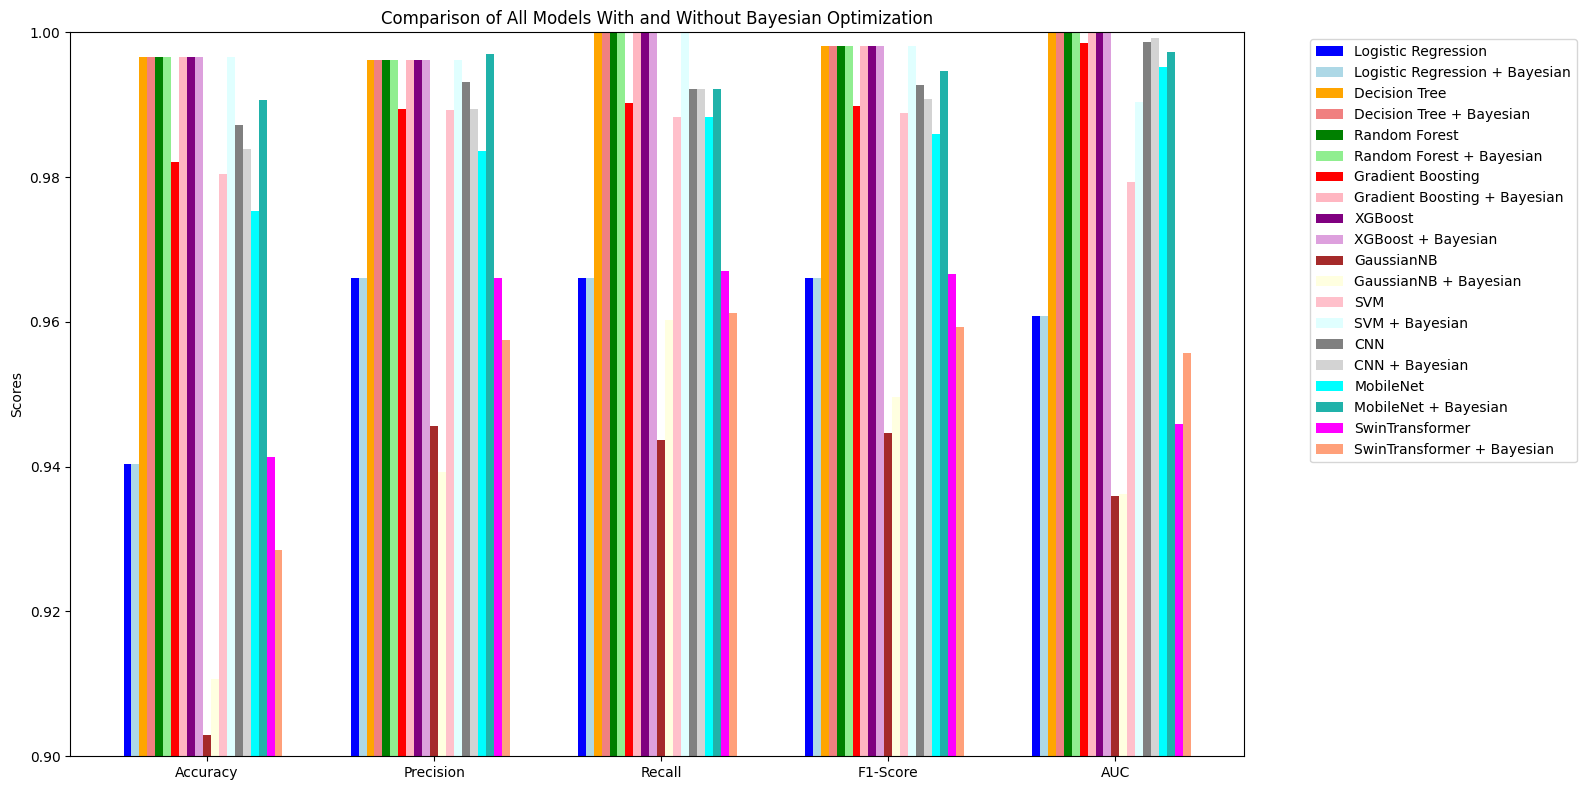

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming metrics_data, metrics_data_with_bayesian, and model_names are defined from the previous code
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
x = np.arange(len(metrics))
width = 0.035  # Adjusted width for multiple bars
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']
bayesian_colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightpink', 'plum', 'lightyellow', 'lightcyan', 'lightgray', 'lightseagreen', 'lightsalmon']

# Create a single figure for all models
plt.figure(figsize=(16, 8))

# Plot bars for each model with and without Bayesian Optimization
for i, model_name in enumerate(model_names):
    # Without Bayesian Optimization
    plt.bar(x + (i * 2 - len(model_names)) * width,
            [metrics_data[m][model_name] for m in metrics],
            width,
            label=model_name,
            color=colors[i % len(colors)])

    # With Bayesian Optimization
    plt.bar(x + (i * 2 - len(model_names) + 1) * width,
            [metrics_data_with_bayesian[m][f"{model_name} + Bayesian Optimization"] for m in metrics],
            width,
            label=f"{model_name} + Bayesian",
            color=bayesian_colors[i % len(bayesian_colors)])

# Customize the plot
plt.ylabel('Scores')
plt.xticks(x, metrics)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0.9, 1.0)
plt.title('Comparison of All Models With and Without Bayesian Optimization')
plt.tight_layout()

# Save and show the plot
plt.savefig('all_models_bayesian_comparison.png')
plt.show()

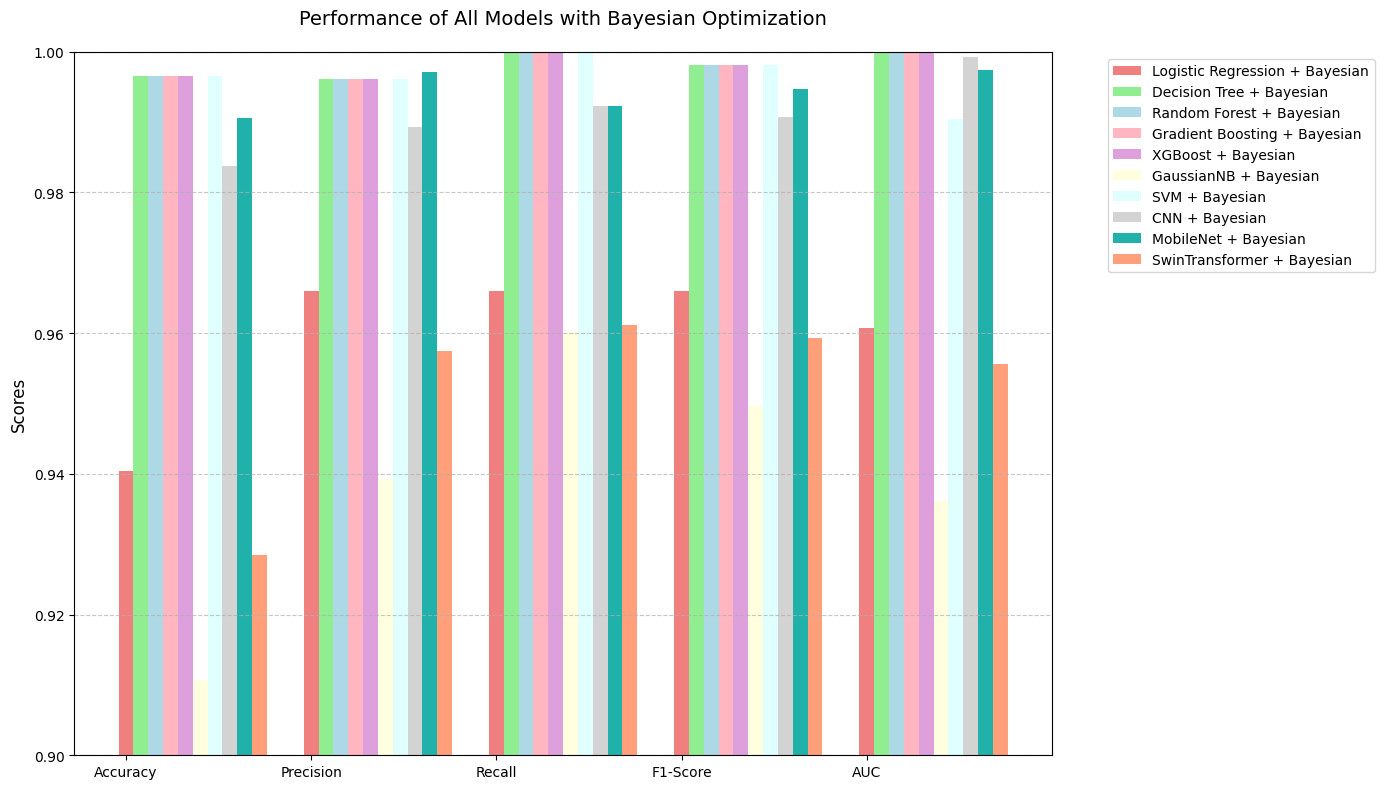

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming metrics_data_with_bayesian and model_names are defined from the previous code
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
x = np.arange(len(metrics))
width = 0.08  # Adjusted width for clarity
colors = ['lightcoral', 'lightgreen', 'lightblue', 'lightpink', 'plum', 'lightyellow', 'lightcyan', 'lightgray', 'lightseagreen', 'lightsalmon']

# Create a single figure for all models with Bayesian Optimization
plt.figure(figsize=(14, 8))

# Plot bars for each model with Bayesian Optimization
for i, model_name in enumerate(model_names):
    plt.bar(x + i * width,
            [metrics_data_with_bayesian[m][f"{model_name} + Bayesian Optimization"] for m in metrics],
            width,
            label=f"{model_name} + Bayesian",
            color=colors[i % len(colors)])

# Customize the plot
plt.ylabel('Scores', fontsize=12)
plt.xticks(x, metrics, fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.ylim(0.9, 1.0)
plt.title('Performance of All Models with Bayesian Optimization', fontsize=14, pad=20)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save and show the plot
plt.savefig('bayesian_optimization_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

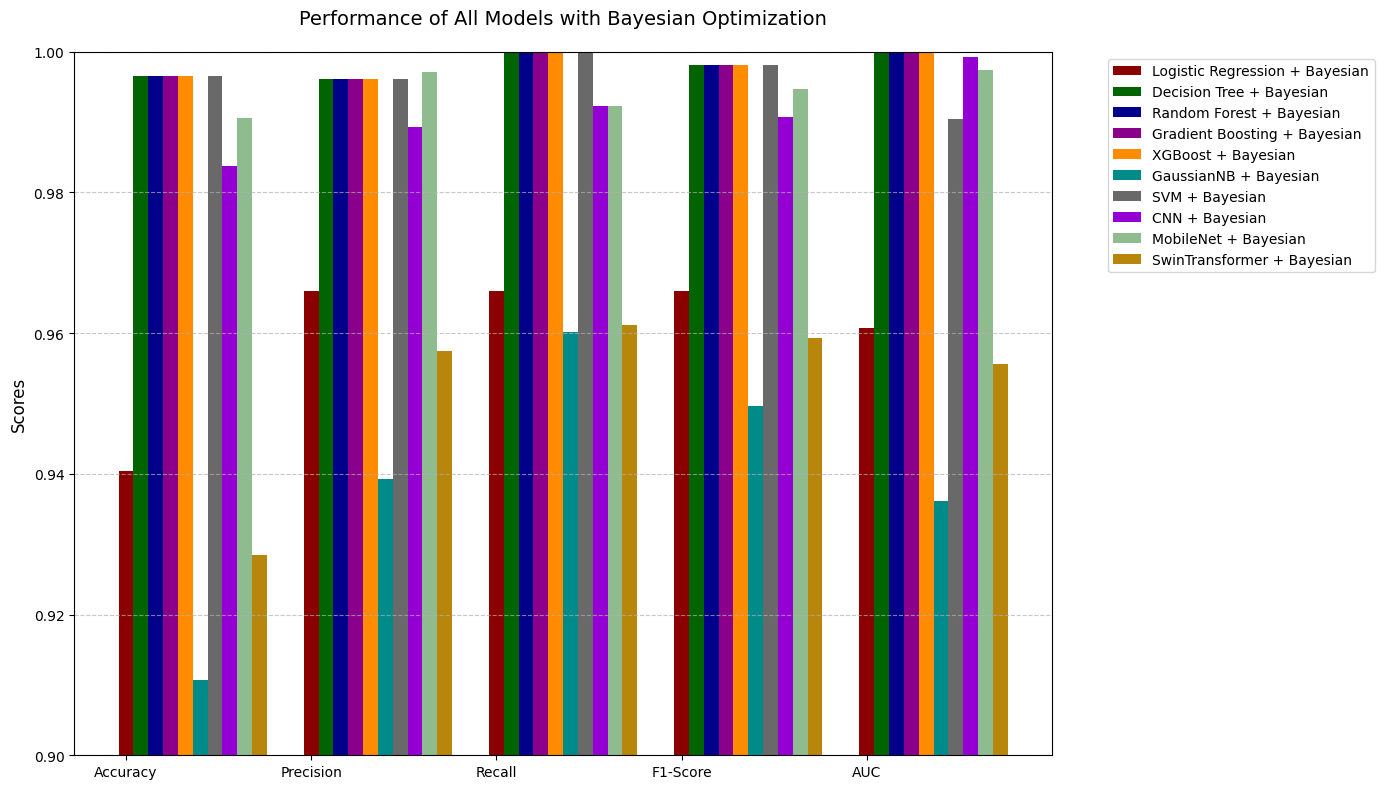

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming metrics_data_with_bayesian and model_names are defined from the previous code
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
x = np.arange(len(metrics))
width = 0.08  # Adjusted width for clarity
colors = ['darkred', 'darkgreen', 'darkblue', 'darkmagenta', 'darkorange', 'darkcyan', 'dimgray', 'darkviolet', 'darkseagreen', 'darkgoldenrod']

# Create a single figure for all models with Bayesian Optimization
plt.figure(figsize=(14, 8))

# Plot bars for each model with Bayesian Optimization
for i, model_name in enumerate(model_names):
    plt.bar(x + i * width,
            [metrics_data_with_bayesian[m][f"{model_name} + Bayesian Optimization"] for m in metrics],
            width,
            label=f"{model_name} + Bayesian",
            color=colors[i % len(colors)])

# Customize the plot
plt.ylabel('Scores', fontsize=12)
plt.xticks(x, metrics, fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.ylim(0.9, 1.0)
plt.title('Performance of All Models with Bayesian Optimization', fontsize=14, pad=20)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save and show the plot
plt.savefig('bayesian_optimization_comparison_dark.png', dpi=300, bbox_inches='tight')
plt.show()

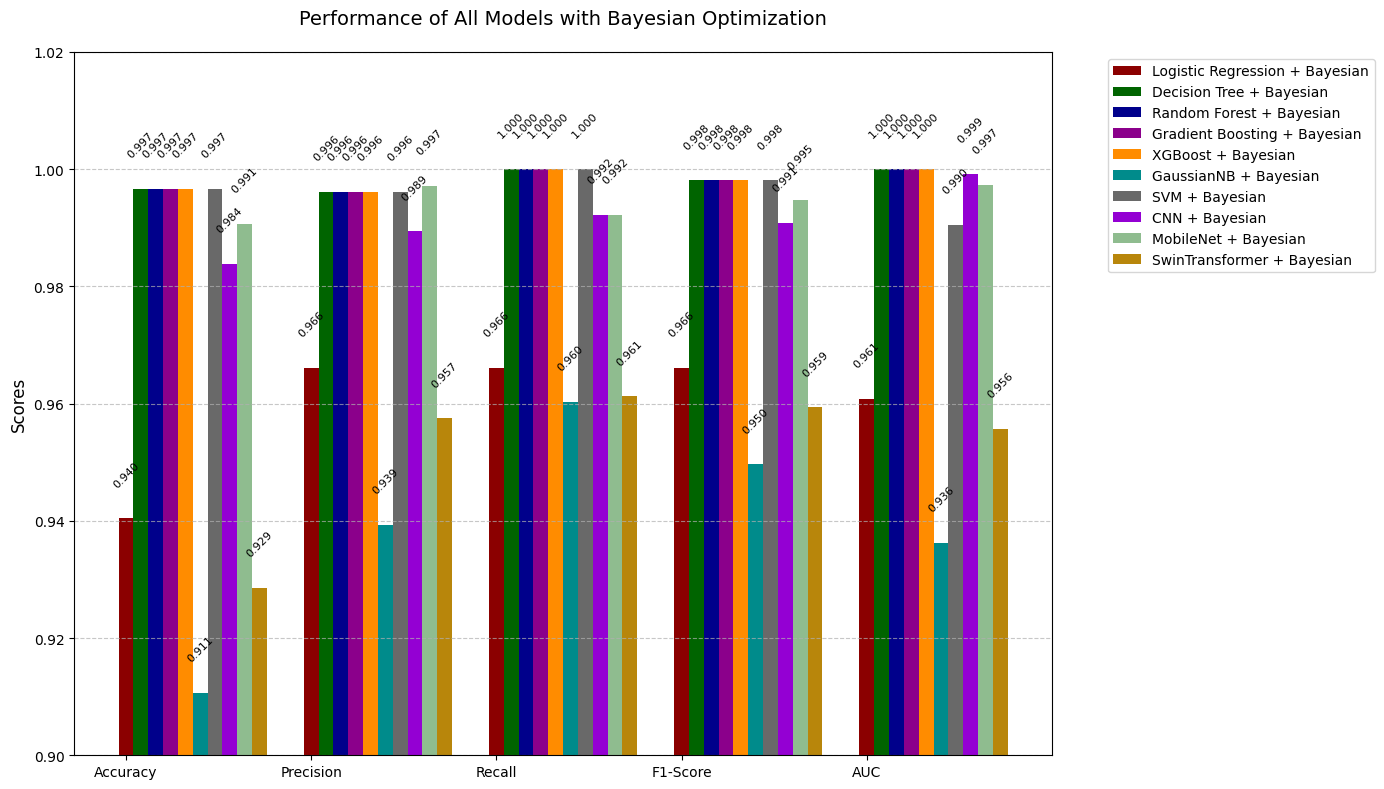

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming metrics_data_with_bayesian and model_names are defined from the previous code
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
x = np.arange(len(metrics))
width = 0.08  # Adjusted width for clarity
colors = ['darkred', 'darkgreen', 'darkblue', 'darkmagenta', 'darkorange', 'darkcyan', 'dimgray', 'darkviolet', 'darkseagreen', 'darkgoldenrod']

# Create a single figure for all models with Bayesian Optimization
plt.figure(figsize=(14, 8))

# Plot bars for each model with Bayesian Optimization
for i, model_name in enumerate(model_names):
    scores = [metrics_data_with_bayesian[m][f"{model_name} + Bayesian Optimization"] for m in metrics]
    bars = plt.bar(x + i * width,
                   scores,
                   width,
                   label=f"{model_name} + Bayesian",
                   color=colors[i % len(colors)])

    # Add text labels on top of each bar
    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005,
                 f'{score:.3f}',
                 ha='center', va='bottom', fontsize=8, rotation=45)

# Customize the plot
plt.ylabel('Scores', fontsize=12)
plt.xticks(x, metrics, fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.ylim(0.9, 1.02)  # Adjusted to accommodate text labels
plt.title('Performance of All Models with Bayesian Optimization', fontsize=14, pad=20)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save and show the plot
plt.savefig('bayesian_optimization_comparison_dark_with_scores.png', dpi=300, bbox_inches='tight')
plt.show()

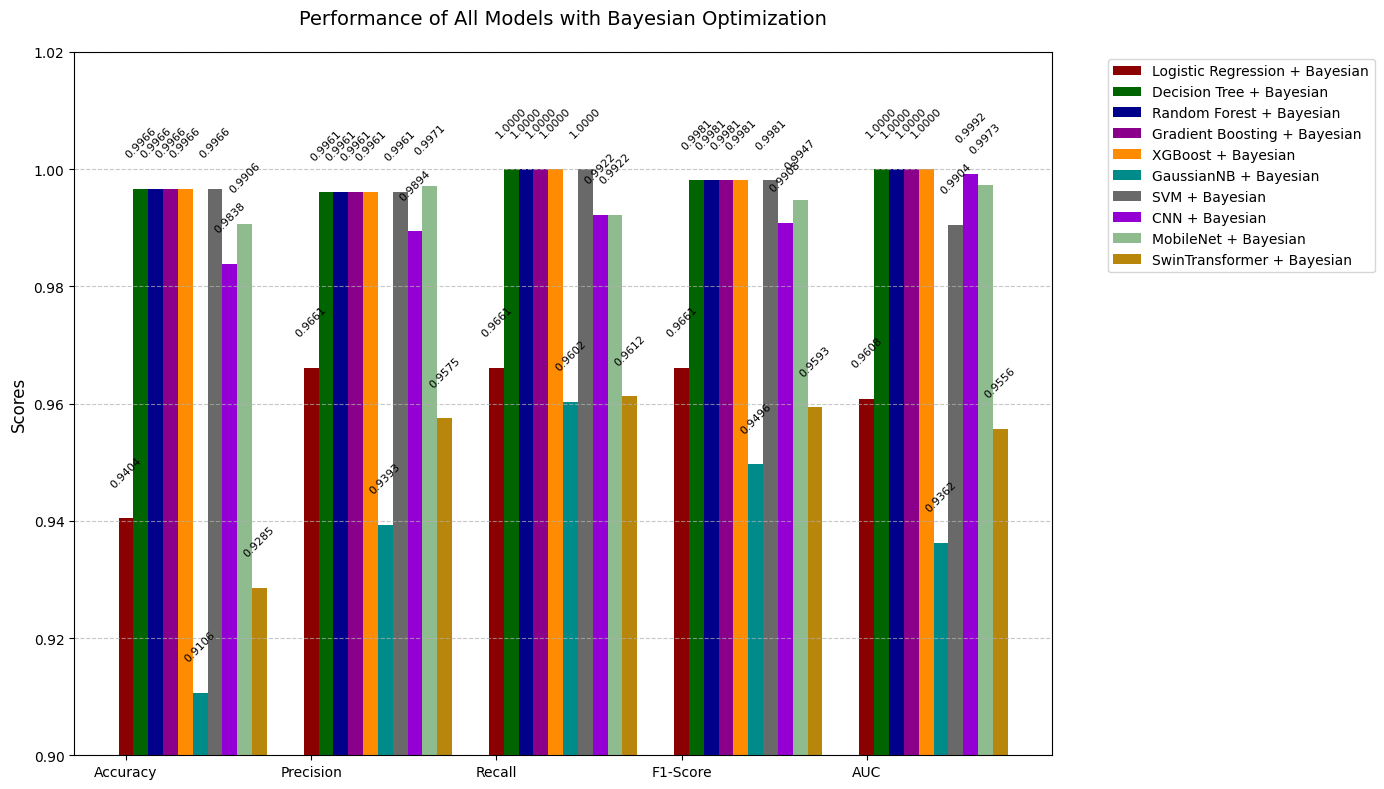

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming metrics_data_with_bayesian and model_names are defined from the previous code
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
x = np.arange(len(metrics))
width = 0.08  # Adjusted width for clarity
colors = ['darkred', 'darkgreen', 'darkblue', 'darkmagenta', 'darkorange', 'darkcyan', 'dimgray', 'darkviolet', 'darkseagreen', 'darkgoldenrod']

# Create a single figure for all models with Bayesian Optimization
plt.figure(figsize=(14, 8))

# Plot bars for each model with Bayesian Optimization
for i, model_name in enumerate(model_names):
    scores = [metrics_data_with_bayesian[m][f"{model_name} + Bayesian Optimization"] for m in metrics]
    bars = plt.bar(x + i * width,
                   scores,
                   width,
                   label=f"{model_name} + Bayesian",
                   color=colors[i % len(colors)])

    # Add text labels on top of each bar with 4 decimal places
    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005,
                 f'{score:.4f}',
                 ha='center', va='bottom', fontsize=8, rotation=45)

# Customize the plot
plt.ylabel('Scores', fontsize=12)
plt.xticks(x, metrics, fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.ylim(0.9, 1.02)  # Adjusted to accommodate text labels
plt.title('Performance of All Models with Bayesian Optimization', fontsize=14, pad=20)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save and show the plot
plt.savefig('bayesian_optimization_comparison_dark_with_scores_4digits.png', dpi=300, bbox_inches='tight')
plt.show()

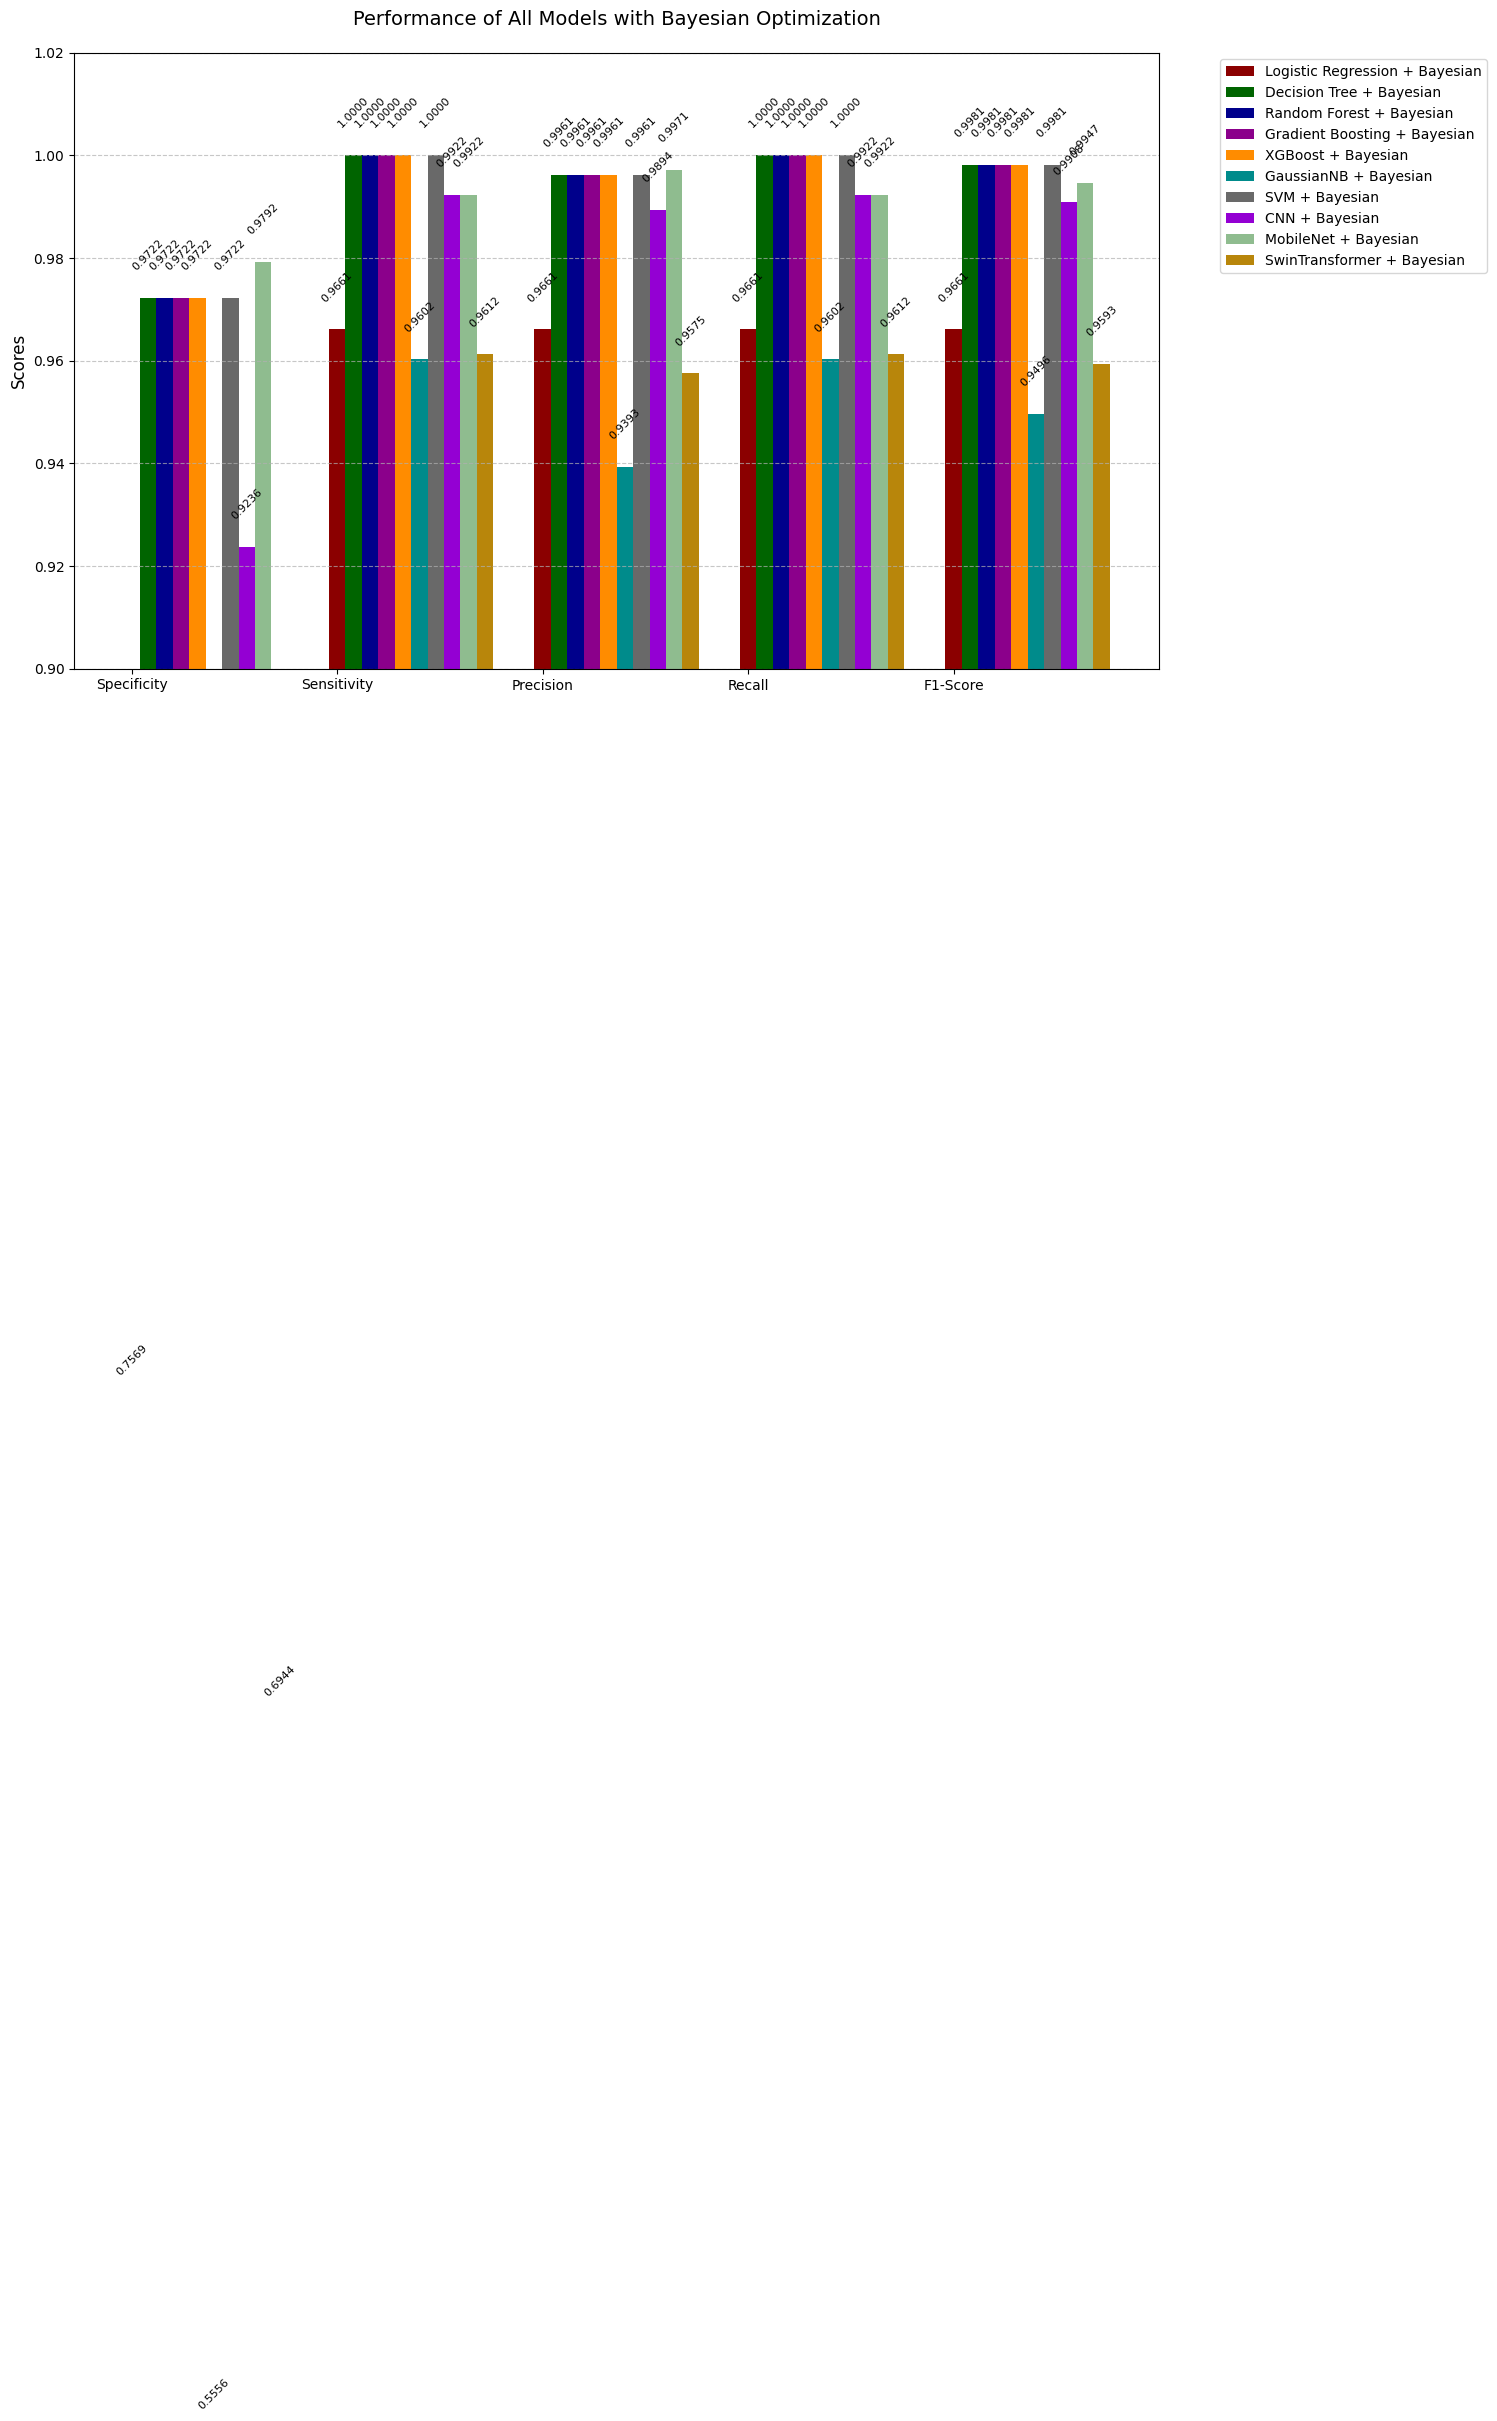

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming metrics_data_with_bayesian, model_names, y_test, and models_with_bayesian are defined from the previous code
metrics = ['Specificity', 'Sensitivity', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.08  # Adjusted width for clarity
colors = ['darkred', 'darkgreen', 'darkblue', 'darkmagenta', 'darkorange', 'darkcyan', 'dimgray', 'darkviolet', 'darkseagreen', 'darkgoldenrod']

# Calculate Specificity and Sensitivity for each model
specificity_scores = {}
sensitivity_scores = {}

for model_name in model_names:
    # Get predictions
    if model_name in ['CNN', 'MobileNet', 'SwinTransformer']:
        if model_name == 'CNN':
            y_prob = models_with_bayesian[f"{model_name} + Bayesian Optimization"].predict(X_test_cnn, verbose=0).flatten()
        else:
            y_prob = models_with_bayesian[f"{model_name} + Bayesian Optimization"].predict(X_test_swin, verbose=0).flatten()
        y_pred = (y_prob >= 0.5).astype(int)
    else:
        y_pred = models_with_bayesian[f"{model_name} + Bayesian Optimization"].predict(X_test_scaled)

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Specificity: TN / (TN + FP)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    specificity_scores[f"{model_name} + Bayesian Optimization"] = specificity

    # Sensitivity: TP / (TP + FN) (same as Recall)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    sensitivity_scores[f"{model_name} + Bayesian Optimization"] = sensitivity

# Create a single figure for all models with Bayesian Optimization
plt.figure(figsize=(14, 8))

# Plot bars for each model with Bayesian Optimization
for i, model_name in enumerate(model_names):
    scores = [
        specificity_scores[f"{model_name} + Bayesian Optimization"],
        sensitivity_scores[f"{model_name} + Bayesian Optimization"],
        metrics_data_with_bayesian['Precision'][f"{model_name} + Bayesian Optimization"],
        metrics_data_with_bayesian['Recall'][f"{model_name} + Bayesian Optimization"],
        metrics_data_with_bayesian['F1-Score'][f"{model_name} + Bayesian Optimization"]
    ]
    bars = plt.bar(x + i * width,
                   scores,
                   width,
                   label=f"{model_name} + Bayesian",
                   color=colors[i % len(colors)])

    # Add text labels on top of each bar with 4 decimal places
    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005,
                 f'{score:.4f}',
                 ha='center', va='bottom', fontsize=8, rotation=45)

# Customize the plot
plt.ylabel('Scores', fontsize=12)
plt.xticks(x, metrics, fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.ylim(0.9, 1.02)  # Adjusted to accommodate text labels
plt.title('Performance of All Models with Bayesian Optimization', fontsize=14, pad=20)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save and show the plot
plt.savefig('bayesian_optimization_specificity_sensitivity_precision_recall_f1score.png', dpi=300, bbox_inches='tight')
plt.show()